## Importing necessary libraries

In [44]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [45]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [46]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from numpy import where
import datetime
import time

## Data loading and preprocessing

In [48]:
file_paths = ['CAD and exercise.csv', 'CAD and exercise1.csv', 'CAD and exercise2.csv',
              'CTG Alzeimers disease and exercise.csv', 'CTG Alzheimer disease and physical activity.csv',
              'CTG Alzheimer disease.csv', 'CTG CAD and phycial activity.csv', 'CTG Cardiac and exercise.csv',
              'CTG Cardio and exercise.csv', 'CTG Cardio and physical activity.csv',
              'CTG Cardiovascular disease and exercise.csv', 'CTG Cardiovascular disease and physical activity.csv',
              'CTG Chronic kidney disease and exercise.csv', 'CTG Chronic kidney disease and physical activity.csv',
              'CTG Diabetes and exercise.csv', 'CTG Diabetes and physical activity.csv',
              'CTG Diabetes mellitus and exercise.csv', 'CTG Diabetes mellitus type 2 and exercise.csv',
              'CTG Diabetes mellitus type 2 and physical activity.csv', 'CTG Kneeosteoarthritis and exercise.csv',
              'CTG Kneeosteoarthritis and physical activity.csv', 'CTG Obesity and exercise.csv',
              'CTG Obesity and physical activity.csv', 'CTG Osteoarthritis and exercise.csv',
              'CTG Osteoarthritis and physical activity.csv', 'CTG PAD and exercise 1.csv',
              'CTG PAD and exercise.csv', 'CTG PAD and physical activity.csv', 'CTG PAD and physical activity1.csv',
              'CTG Physical activity and CAD.csv', 'CTG heart and exercise.csv', 'CTG stroke and exercise.csv',
              'CTG stroke and exercise1.csv', 'CTG stroke and physical activity.csv',
              'CTG stroke and physical activity1.csv', 'CTG studies diabetes and physical activity.csv']

In [49]:
clinical_trial_dataframes = [pd.read_csv(file) for file in file_paths]
ct_data = pd.concat(clinical_trial_dataframes, ignore_index=True)

In [50]:
def preprocess_data(data):
    # Handle missing values
    data.dropna(subset=['Conditions', 'Interventions'], inplace=True)
    # Drop irrelevant columns
    columns_to_drop = ['Study Title', 'Study URL', 'Acronym', 'Study Status', 'Brief Summary', 'Study Results',
                   'Sponsor', 'Collaborators', 'Phases', 'Funder Type', 'Study Type', 'Study Design',
                   'Start Date', 'Primary Completion Date', 'Completion Date', 'First Posted', 'Results First Posted',
                   'Last Update Posted', 'Locations', 'Study Documents']
    data.drop(columns=columns_to_drop, inplace=True)
    return data


preprocessed_data = preprocess_data(ct_data)

In [51]:
preprocessed_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1080 entries, 0 to 1079
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   NCT Number                  1080 non-null   object 
 1   Conditions                  1080 non-null   object 
 2   Interventions               1080 non-null   object 
 3   Primary Outcome Measures    1080 non-null   object 
 4   Secondary Outcome Measures  904 non-null    object 
 5   Other Outcome Measures      216 non-null    object 
 6   Sex                         1077 non-null   object 
 7   Age                         1080 non-null   object 
 8   Enrollment                  1080 non-null   float64
 9   Other IDs                   1080 non-null   object 
 10  Total number of studies     0 non-null      object 
 11  1158                        0 non-null      object 
 12  Unnamed: 2                  0 non-null      float64
 13  Unnamed: 3                  0 non-null

## Extracting Exercise-Related Data

In [52]:
# Filter rows containing exercise-related interventions
exercise_data = preprocessed_data[preprocessed_data['Interventions'].str.contains('Exercise', case=False, na=False)]

In [53]:
exercise_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182 entries, 0 to 1062
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   NCT Number                  182 non-null    object 
 1   Conditions                  182 non-null    object 
 2   Interventions               182 non-null    object 
 3   Primary Outcome Measures    182 non-null    object 
 4   Secondary Outcome Measures  142 non-null    object 
 5   Other Outcome Measures      21 non-null     object 
 6   Sex                         182 non-null    object 
 7   Age                         182 non-null    object 
 8   Enrollment                  182 non-null    float64
 9   Other IDs                   182 non-null    object 
 10  Total number of studies     0 non-null      object 
 11  1158                        0 non-null      object 
 12  Unnamed: 2                  0 non-null      float64
 13  Unnamed: 3                  0 non-null 

## Preprocessing exercise-data

# checking for conditions

In [54]:
conditions_counts = exercise_data['Conditions'].value_counts().reset_index()
conditions_counts.columns = ['Condition', 'Total Count']
print(conditions_counts.to_string(index=False))


                                                                                                           Condition  Total Count
                                                                                                             Obesity           10
                                                                           Postural Orthostatic Tachycardia Syndrome           10
                                                                 Obesity|Heart Failure, Diastolic|Metabolic Syndrome            9
                                                                                             Coronary Artery Disease            9
                      Vascular Disease, Peripheral|Physical Inactivity|Arterial Hypertension|Endothelial Dysfunction            8
                                                          Prehypertension|Blood Pressure|Abdominal Obesity|Adiposity            7
                                                  Type2 Diabetes Mellitus|Hyperglycemia|He

# Interventions for Obesity

In [55]:
# Filter the clinical trials data based on conditions
condition_data = exercise_data[exercise_data['Conditions'].str.contains('Obesity')]

# Extract exercise interventions and outcomes for the condition
interventions = condition_data['Interventions'].tolist()
primary_outcomes = condition_data['Primary Outcome Measures'].tolist()
secondary_outcomes = condition_data['Secondary Outcome Measures'].tolist()

# Print the exercise interventions and outcomes for the condition
print("Exercise Interventions for Obesity:")
for intervention, primary, secondary in zip(interventions, primary_outcomes, secondary_outcomes):
    print(f"Intervention: {intervention}")
    print(f"Primary Outcomes: {primary}")
    print(f"Secondary Outcomes: {secondary}")
    print("---")

Exercise Interventions for Obesity:
Intervention: OTHER: Jump rope exercise intervention
Primary Outcomes: Arterial Stiffness, Arterial stiffness was measured as measurement of brachial to ankle pulse-wave velocity. This indicates peripheral arterial stiffness, as it measures how quickly a pulse wave propagates from one point to another., 12 weeks|Endothelin-1, Levels of Endothelin-1 in blood were measured by Endothelin-1 enzyme immunoassay kit., 12 weeks|Body Mass, Body mass was measured to nearest 0.1 kg., 12 weeks|Height, Height was measured to nearest 1 cm., 12 weeks|Waist Circumference, Waist circumference was measured at midpoint between the lower rib and the iliac crest at the end of a normal expiration using a tape measure., 12 weeks|Body Fat, Percent body fat (%) was determined using a bioelectrical impedance-meter., 12 weeks|Lean Body Mass, Lean body mass (kg) was determined using a bioelectrical impedance-meter., 12 weeks|Nitrate/Nitrite Levels, Nitrate and nitrite levels we

In [56]:
from collections import Counter

# Count the frequency of exercise interventions for obesity
intervention_counts = Counter(interventions)

# Print the frequency of each intervention
print("Frequency of Exercise Interventions for Obesity:")
for intervention, count in intervention_counts.items():
    print(f"{intervention}: {count}")

Frequency of Exercise Interventions for Obesity:
OTHER: Jump rope exercise intervention: 7
BEHAVIORAL: High intensity exercise|DIETARY_SUPPLEMENT: Omega-3 fish oil|BEHAVIORAL: Yoga|DIETARY_SUPPLEMENT: olive oil capsules: 9
BEHAVIORAL: Exercise: 4
BEHAVIORAL: High dosage in-person exercise coaching|BEHAVIORAL: Medium dosage in-person exercise coaching.|BEHAVIORAL: Low dosage in-person exercise coaching: 2
DIETARY_SUPPLEMENT: Beetroot Juice|OTHER: Exercise Training: 2
BEHAVIORAL: Approach-Avoidance Bias Modification|BEHAVIORAL: Inhibition Training|BEHAVIORAL: Implementation of Intentions|BEHAVIORAL: Episodic Future Thinking|BEHAVIORAL: Sham Approach-Avoidance Bias Modification|BEHAVIORAL: Sham Inhibition Treatment|BEHAVIORAL: Setting Intentions|BEHAVIORAL: Recent Episodic Thinking|BEHAVIORAL: Motivational Interviewing|BEHAVIORAL: Nutritional intervention|BEHAVIORAL: Physical exercise intervention: 2
DRUG: Liraglutide|BEHAVIORAL: Exercise: 2
BEHAVIORAL: Exercise training: 2
DEVICE: ECAL I

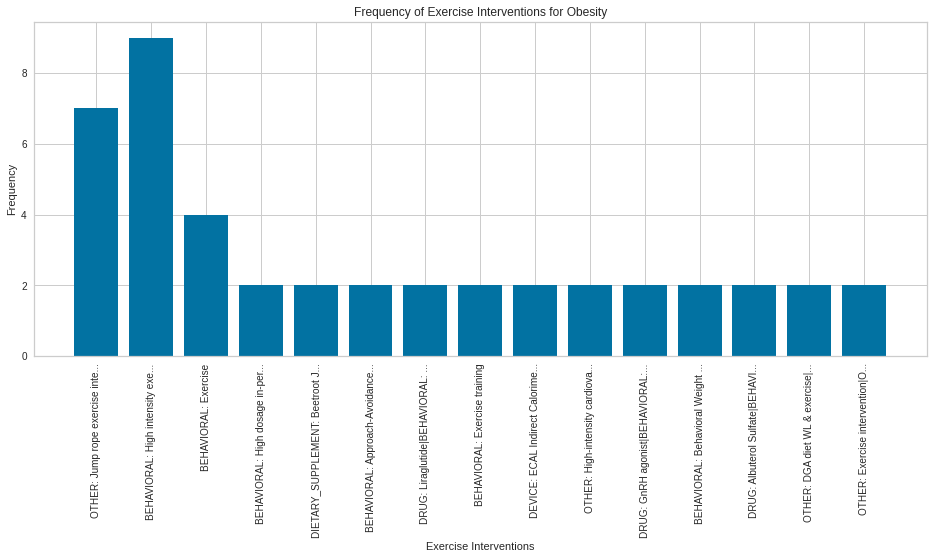

In [57]:
import matplotlib.pyplot as plt

# Filter the clinical trials data based on conditions
condition_data = exercise_data[exercise_data['Conditions'].str.contains('Obesity')]

# Extract exercise interventions for the condition
interventions = condition_data['Interventions'].tolist()

# Count the frequency of exercise interventions
intervention_counts = Counter(interventions)

# Prepare data for the bar chart
interventions = list(intervention_counts.keys())
frequencies = list(intervention_counts.values())

# Truncate long intervention names
max_length = 30
interventions = [intervention[:max_length] + '...' if len(intervention) > max_length else intervention for intervention in interventions]

# Create a bar chart
plt.figure(figsize=(16, 8))
plt.bar(interventions, frequencies)
plt.xlabel('Exercise Interventions')
plt.ylabel('Frequency')
plt.title('Frequency of Exercise Interventions for Obesity')
plt.xticks(rotation=90, ha='center')
plt.subplots_adjust(bottom=0.3)
plt.show()

## feature selection and encoding

In [58]:
# 3. Feature Engineering and Selection
def engineer_features(data):

    # Perform feature engineering
    conditions_split = exercise_data['Conditions'].str.split('|', expand=True)
    conditions_split.columns = [f'Condition_{i}' for i in range(1, conditions_split.shape[1] + 1)]
    conditions_encoded = pd.get_dummies(conditions_split, prefix='Condition')

    intervention_types = exercise_data['Interventions'].str.split(':', n=1, expand=True)[0]
    intervention_types_encoded = pd.get_dummies(intervention_types, prefix='Intervention')

    sex_encoded = pd.get_dummies(exercise_data['Sex'], prefix='Sex')
    age_encoded = pd.get_dummies(exercise_data['Age'], prefix='Age')

    exercise_features = pd.concat([conditions_encoded, intervention_types_encoded, sex_encoded, age_encoded], axis=1)
    return exercise_data, exercise_features

exercise_data, exercise_features = engineer_features(preprocessed_data)




In [59]:
exercise_data

,NCT Number,Conditions,Interventions,Primary Outcome Measures,Secondary Outcome Measures,Other Outcome Measures,Sex,Age,Enrollment,Other IDs,Total number of studies,1158,Unnamed: 2,Unnamed: 3,Type Intervention,Unnamed: 5,Total number of patients
0,NCT03534427,Prehypertension|Blood Pressure|Abdominal Obesi...,OTHER: Jump rope exercise intervention,"Arterial Stiffness, Arterial stiffness was mea...",NaN,NaN,FEMALE,CHILD,40.0,PusanNU1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NCT04009629,Alzheimer Disease 2 Due to Apoe4 Isoform|Healt...,BEHAVIORAL: Moderate Intensity Aerobic Exercise,"Cerebral Blood Flow Area Under Curve, Cumulati...","Insulin-like Growth Factor-1 Change, Change in...",NaN,ALL,OLDER_ADULT,61.0,STUDY00142822|R21AG061548,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NCT03448185,"Obesity|Heart Failure, Diastolic|Metabolic Syn...",BEHAVIORAL: High intensity exercise|DIETARY_SU...,Change From Baseline at 1 Year in Myocardial L...,Change From Baseline at 1 Year in Peak Volume ...,NaN,ALL,ADULT,80.0,STU 062014-067,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NCT01109992,Coronary Artery Disease,DRUG: Exercise plus Regadenoson (Lexercise)|DR...,Safety and Tolerability of Combined Exercise a...,"Image Quality: Heart to Liver Ratio of Counts,...",NaN,ALL,"ADULT, OLDER_ADULT",43.0,BWH,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NCT03197038,"Cognitive Function, Preclinical|Chronic Kidney...",BEHAVIORAL: Partially supervised home-based wa...,"Composite Global Cognitive Function, Determine...","White Matter Integrity, Whole brain white matt...",NaN,ALL,"ADULT, OLDER_ADULT",39.0,2016-1217|P30AG022849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030,NCT03370471,Aging|Aphasia,BEHAVIORAL: Retrieval Practice + Moderate Inte...,"Study-Specific Word Recall Task, Study-specifi...","Serum BDNF Concentration Levels (pg/mL), Blood...",NaN,ALL,"ADULT, OLDER_ADULT",28.0,C2238-P,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1040,NCT05115149,Stroke|Spinal Cord Injuries,DEVICE: VIBRAINT RehUp robotic orthosis|PROCED...,Change from Baseline Fugl-Meyer scale for the ...,Change from Baseline Accuracy of BCI tasks aft...,NaN,ALL,ADULT,60.0,Skoltech-CNBR1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1041,NCT03370471,Aging|Aphasia,BEHAVIORAL: Retrieval Practice + Moderate Inte...,"Study-Specific Word Recall Task, Study-specifi...","Serum BDNF Concentration Levels (pg/mL), Blood...",NaN,ALL,"ADULT, OLDER_ADULT",28.0,C2238-P,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1061,NCT05115149,Stroke|Spinal Cord Injuries,DEVICE: VIBRAINT RehUp robotic orthosis|PROCED...,Change from Baseline Fugl-Meyer scale for the ...,Change from Baseline Accuracy of BCI tasks aft...,NaN,ALL,ADULT,60.0,Skoltech-CNBR1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
exercise_features

,Condition_Aging,Condition_Alzheimer Disease 2 Due to Apoe4 Isoform,Condition_Arthroplasty,Condition_Asthma in Children,Condition_Cardiovascular Diseases,Condition_Cardiovascular Risk Factor,Condition_Child Mental Disorders,Condition_Chronic Mesenteric Ischemia,Condition_Cigarette Smoking,"Condition_Cognitive Function, Preclinical",...,Intervention_RADIATION,Sex_ALL,Sex_FEMALE,Sex_MALE,Age_ADULT,"Age_ADULT, OLDER_ADULT",Age_CHILD,"Age_CHILD, ADULT","Age_CHILD, ADULT, OLDER_ADULT",Age_OLDER_ADULT
0,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
3,False,True,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
4,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,True,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,True,False,False,False,False
11,False,False,False,False,False,False,False,False,False,True,...,False,True,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030,True,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,True,False,False,False,False
1040,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,True,False,False,False,False,False
1041,True,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,True,False,False,False,False
1061,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,True,False,False,False,False,False


In [61]:
# Merge exercise_features and exercise_data based on index
merged_data = pd.concat([exercise_data.reset_index(drop=True), exercise_features.reset_index(drop=True)], axis=1)
merged_data

,NCT Number,Conditions,Interventions,Primary Outcome Measures,Secondary Outcome Measures,Other Outcome Measures,Sex,Age,Enrollment,Other IDs,...,Intervention_RADIATION,Sex_ALL,Sex_FEMALE,Sex_MALE,Age_ADULT,"Age_ADULT, OLDER_ADULT",Age_CHILD,"Age_CHILD, ADULT","Age_CHILD, ADULT, OLDER_ADULT",Age_OLDER_ADULT
0,NCT03534427,Prehypertension|Blood Pressure|Abdominal Obesi...,OTHER: Jump rope exercise intervention,"Arterial Stiffness, Arterial stiffness was mea...",NaN,NaN,FEMALE,CHILD,40.0,PusanNU1,...,False,False,True,False,False,False,True,False,False,False
1,NCT04009629,Alzheimer Disease 2 Due to Apoe4 Isoform|Healt...,BEHAVIORAL: Moderate Intensity Aerobic Exercise,"Cerebral Blood Flow Area Under Curve, Cumulati...","Insulin-like Growth Factor-1 Change, Change in...",NaN,ALL,OLDER_ADULT,61.0,STUDY00142822|R21AG061548,...,False,True,False,False,False,False,False,False,False,True
2,NCT03448185,"Obesity|Heart Failure, Diastolic|Metabolic Syn...",BEHAVIORAL: High intensity exercise|DIETARY_SU...,Change From Baseline at 1 Year in Myocardial L...,Change From Baseline at 1 Year in Peak Volume ...,NaN,ALL,ADULT,80.0,STU 062014-067,...,False,True,False,False,True,False,False,False,False,False
3,NCT01109992,Coronary Artery Disease,DRUG: Exercise plus Regadenoson (Lexercise)|DR...,Safety and Tolerability of Combined Exercise a...,"Image Quality: Heart to Liver Ratio of Counts,...",NaN,ALL,"ADULT, OLDER_ADULT",43.0,BWH,...,False,True,False,False,False,True,False,False,False,False
4,NCT03197038,"Cognitive Function, Preclinical|Chronic Kidney...",BEHAVIORAL: Partially supervised home-based wa...,"Composite Global Cognitive Function, Determine...","White Matter Integrity, Whole brain white matt...",NaN,ALL,"ADULT, OLDER_ADULT",39.0,2016-1217|P30AG022849,...,False,True,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,NCT03370471,Aging|Aphasia,BEHAVIORAL: Retrieval Practice + Moderate Inte...,"Study-Specific Word Recall Task, Study-specifi...","Serum BDNF Concentration Levels (pg/mL), Blood...",NaN,ALL,"ADULT, OLDER_ADULT",28.0,C2238-P,...,False,True,False,False,False,True,False,False,False,False
178,NCT05115149,Stroke|Spinal Cord Injuries,DEVICE: VIBRAINT RehUp robotic orthosis|PROCED...,Change from Baseline Fugl-Meyer scale for the ...,Change from Baseline Accuracy of BCI tasks aft...,NaN,ALL,ADULT,60.0,Skoltech-CNBR1,...,False,True,False,False,True,False,False,False,False,False
179,NCT03370471,Aging|Aphasia,BEHAVIORAL: Retrieval Practice + Moderate Inte...,"Study-Specific Word Recall Task, Study-specifi...","Serum BDNF Concentration Levels (pg/mL), Blood...",NaN,ALL,"ADULT, OLDER_ADULT",28.0,C2238-P,...,False,True,False,False,False,True,False,False,False,False
180,NCT05115149,Stroke|Spinal Cord Injuries,DEVICE: VIBRAINT RehUp robotic orthosis|PROCED...,Change from Baseline Fugl-Meyer scale for the ...,Change from Baseline Accuracy of BCI tasks aft...,NaN,ALL,ADULT,60.0,Skoltech-CNBR1,...,False,True,False,False,True,False,False,False,False,False


## Clustering

In [62]:
# Perform clustering on the merged_data
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(exercise_features)
merged_data['Cluster'] = clusters
clusters

array([0, 2, 1, 0, 2, 0, 2, 1, 0, 0, 2, 2, 2, 0, 2, 1, 0, 2, 0, 2, 2, 1,
       2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 1, 2, 2, 0, 0, 2, 0, 2, 0, 2, 2,
       2, 0, 0, 2, 0, 2, 2, 2, 1, 2, 2, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2,
       0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2,
       0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 1, 0, 0, 1, 1, 0, 1, 2, 1,
       0, 2, 0, 0, 1, 2, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 2, 1, 0, 2, 0, 0,
       1, 2, 0, 0, 2, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2,
       2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 1, 2, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2], dtype=int32)

In [63]:
# Assign meaningful labels to clusters
cluster_labels = {
    0: 'Adult Females with Aging Conditions',
    1: 'Adults with Cardiovascular and Behavioral Conditions',
    2: 'Mixed Age Group with Cognitive and Respiratory Conditions'
}
merged_data['Target'] = merged_data['Cluster'].map(cluster_labels)

In [64]:
from sklearn.preprocessing import LabelEncoder

# Map cluster labels to 'Target' column
merged_data['Conditions'] = merged_data['Cluster'].map(cluster_labels)

# Create a label encoder object
label_encoder = LabelEncoder()

# Encode the 'Target' column
merged_data['Target_encoded'] = label_encoder.fit_transform(merged_data['Conditions'].values.ravel())

In [65]:
from sklearn.impute import SimpleImputer

# Impute missing values with the mean value
imputer = SimpleImputer(strategy='mean')
exercise_features_imputed = imputer.fit_transform(exercise_features)
target_encoded_imputed = imputer.fit_transform(merged_data['Target_encoded'].values.reshape(-1, 1))

# Create a dataset for clustering with imputed data
data_for_clustering = pd.concat([pd.DataFrame(exercise_features_imputed), pd.Series(target_encoded_imputed.ravel())], axis=1)

In [66]:
# Create a copy of merged_data without missing values
merged_data_cleaned = merged_data.dropna(subset=list(exercise_features.columns) + ['Target_encoded'])

# Create a dataset for clustering by concatenating features and target variable
data_for_clustering = pd.concat([merged_data_cleaned[exercise_features.columns], merged_data_cleaned['Target_encoded']], axis=1)

# Perform clustering on the combined dataset
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(data_for_clustering)

# Add the cluster assignments to the cleaned DataFrame
merged_data_cleaned['Cluster'] = clusters

# (Optional) Merge the cleaned DataFrame with the original DataFrame
merged_data = merged_data.merge(merged_data_cleaned[['Cluster']], how='left', left_index=True, right_index=True)

print(clusters)

[0 2 2 0 2 0 2 2 0 0 2 2 2 0 2 2 0 2 0 2 2 2 2 0 0 0 0 0 2 0 2 2 1 2 2 2 0
 0 2 0 2 0 2 2 2 0 0 2 0 2 2 1 2 2 2 0 0 2 0 2 0 2 2 2 2 2 0 0 0 2 0 2 0 0
 0 2 0 2 0 0 0 2 0 2 0 0 0 2 0 0 0 2 2 0 2 0 2 0 2 0 0 2 0 0 2 2 0 2 1 2 0
 2 0 0 2 2 0 0 0 2 0 0 2 2 0 2 1 2 0 2 0 0 2 2 0 0 2 0 2 2 0 2 0 2 2 0 2 1
 0 2 2 1 0 2 2 1 0 2 2 1 0 2 0 2 0 2 0 2 2 2 2 0 0 0 2 2 2 2 2 2 2 2]


In [67]:
unique_classes = np.unique(merged_data['Target'])
print(unique_classes)

['Adult Females with Aging Conditions'
 'Adults with Cardiovascular and Behavioral Conditions'
 'Mixed Age Group with Cognitive and Respiratory Conditions']


In [68]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(exercise_features_imputed)

In [69]:
# Perform K-means clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_data)
kmeans_labels

array([1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int32)

In [70]:
# Impute missing values in exercise_features
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
exercise_features_imputed = imputer.fit_transform(exercise_features)

# Convert the imputed data back to a DataFrame
exercise_features_imputed = pd.DataFrame(exercise_features_imputed, columns=exercise_features.columns)

# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(exercise_features_imputed)

# Perform K-means clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_data)

# Add the cluster assignments to the merged_data DataFrame
merged_data['Cluster'] = kmeans_labels


In [71]:
# Perform clustering on the merged_data
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(exercise_features)
merged_data['Cluster'] = clusters
clusters

array([0, 2, 1, 0, 2, 0, 2, 1, 0, 0, 2, 2, 2, 0, 2, 1, 0, 2, 0, 2, 2, 1,
       2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 1, 2, 2, 0, 0, 2, 0, 2, 0, 2, 2,
       2, 0, 0, 2, 0, 2, 2, 2, 1, 2, 2, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2,
       0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2,
       0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 1, 0, 0, 1, 1, 0, 1, 2, 1,
       0, 2, 0, 0, 1, 2, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 2, 1, 0, 2, 0, 0,
       1, 2, 0, 0, 2, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2,
       2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 1, 2, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2], dtype=int32)

In [72]:
# Perform hierarchical clustering with different linkage methods
from sklearn.cluster import AgglomerativeClustering
hierarchical_ward = AgglomerativeClustering(n_clusters=3, linkage='ward')
hierarchical_labels_ward = hierarchical_ward.fit_predict(scaled_data)

hierarchical_complete = AgglomerativeClustering(n_clusters=3, linkage='complete')
hierarchical_labels_complete = hierarchical_complete.fit_predict(scaled_data)

hierarchical_average = AgglomerativeClustering(n_clusters=3, linkage='average')
hierarchical_labels_average = hierarchical_average.fit_predict(scaled_data)

In [73]:
from sklearn.metrics import silhouette_score

# Calculate Silhouette Score
silhouette_kmeans = silhouette_score(scaled_data, kmeans_labels, metric='euclidean')  # Silhouette Score doesn't require 'average'
silhouette_hierarchical_ward = silhouette_score(scaled_data, hierarchical_labels_ward, metric='euclidean')
silhouette_hierarchical_complete = silhouette_score(scaled_data, hierarchical_labels_complete, metric='euclidean')
silhouette_hierarchical_average = silhouette_score(scaled_data, hierarchical_labels_average, metric='euclidean')
print("Silhouette Score (K-means):", silhouette_kmeans)
print("Silhouette Score (Hierarchical - Ward):", silhouette_hierarchical_ward)
print("Silhouette Score (Hierarchical - Complete):", silhouette_hierarchical_complete)
print("Silhouette Score (Hierarchical - Average):", silhouette_hierarchical_average)

Silhouette Score (K-means): 0.06620047263041345
Silhouette Score (Hierarchical - Ward): 0.22515398415649834
Silhouette Score (Hierarchical - Complete): 0.3850158438270504
Silhouette Score (Hierarchical - Average): 0.3850158438270504


In [74]:
!pip install yellowbrick

Defaulting to user installation because normal site-packages is not writeable


The Silhouette score measures how well each data point fits into its assigned cluster, with values ranging from -1 to 1.
A higher Silhouette score indicates better-defined clusters, where data points are well-matched to their own cluster and poorly-matched to neighboring clusters.
The Silhouette Visualizer can be used to determine the optimal number of clusters by plotting the average Silhouette score for different values of k, and identifying the value of k with the highest score.
The Silhouette method is considered more reliable than the Elbow method, especially when the elbow point is not clearly defined.

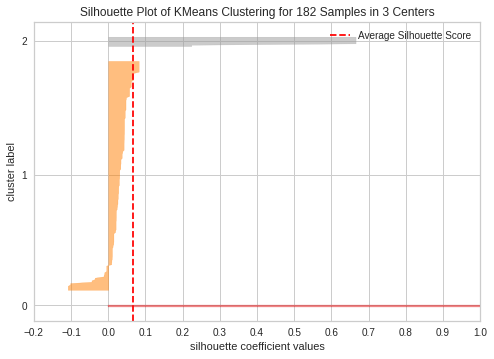

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 182 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [75]:
from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import SilhouetteVisualizer

# Visualize silhouette plots
from yellowbrick.cluster import SilhouetteVisualizer
visualizer = SilhouetteVisualizer(KMeans(n_clusters=3, random_state=42))
visualizer.fit(scaled_data)
visualizer.show()

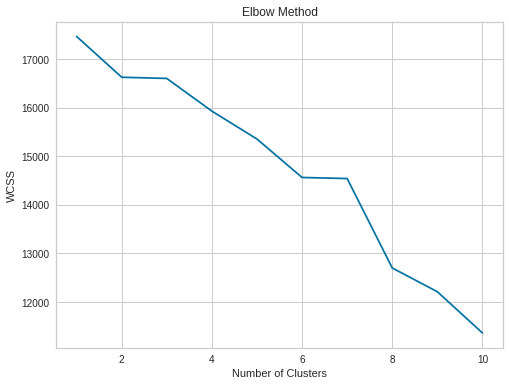

In [76]:
# Elbow method for K-means
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

# Oversampling with Random OverSampler

In [77]:
!pip install imblearn

Defaulting to user installation because normal site-packages is not writeable


In [78]:
from imblearn.over_sampling import RandomOverSampler

# Separate features and target variable
X = exercise_features
y = merged_data['Target']

# Perform oversampling to address class imbalance
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Merge the oversampled data with the original exercise_data
merged_data1 = pd.concat([merged_data, 
                        pd.DataFrame(X_resampled, columns=X.columns), 
                        pd.DataFrame(y_resampled, columns=['Target'])], 
                       axis=1)
merged_data1



,NCT Number,Conditions,Interventions,Primary Outcome Measures,Secondary Outcome Measures,Other Outcome Measures,Sex,Age,Enrollment,Other IDs,...,Sex_ALL,Sex_FEMALE,Sex_MALE,Age_ADULT,"Age_ADULT, OLDER_ADULT",Age_CHILD,"Age_CHILD, ADULT","Age_CHILD, ADULT, OLDER_ADULT",Age_OLDER_ADULT,Target
0,NCT03534427,Adult Females with Aging Conditions,OTHER: Jump rope exercise intervention,"Arterial Stiffness, Arterial stiffness was mea...",NaN,NaN,FEMALE,CHILD,40.0,PusanNU1,...,False,True,False,False,False,True,False,False,False,Adult Females with Aging Conditions
1,NCT04009629,Mixed Age Group with Cognitive and Respiratory...,BEHAVIORAL: Moderate Intensity Aerobic Exercise,"Cerebral Blood Flow Area Under Curve, Cumulati...","Insulin-like Growth Factor-1 Change, Change in...",NaN,ALL,OLDER_ADULT,61.0,STUDY00142822|R21AG061548,...,True,False,False,False,False,False,False,False,True,Mixed Age Group with Cognitive and Respiratory...
2,NCT03448185,Adults with Cardiovascular and Behavioral Cond...,BEHAVIORAL: High intensity exercise|DIETARY_SU...,Change From Baseline at 1 Year in Myocardial L...,Change From Baseline at 1 Year in Peak Volume ...,NaN,ALL,ADULT,80.0,STU 062014-067,...,True,False,False,True,False,False,False,False,False,Adults with Cardiovascular and Behavioral Cond...
3,NCT01109992,Adult Females with Aging Conditions,DRUG: Exercise plus Regadenoson (Lexercise)|DR...,Safety and Tolerability of Combined Exercise a...,"Image Quality: Heart to Liver Ratio of Counts,...",NaN,ALL,"ADULT, OLDER_ADULT",43.0,BWH,...,True,False,False,False,True,False,False,False,False,Adult Females with Aging Conditions
4,NCT03197038,Mixed Age Group with Cognitive and Respiratory...,BEHAVIORAL: Partially supervised home-based wa...,"Composite Global Cognitive Function, Determine...","White Matter Integrity, Whole brain white matt...",NaN,ALL,"ADULT, OLDER_ADULT",39.0,2016-1217|P30AG022849,...,True,False,False,False,True,False,False,False,False,Mixed Age Group with Cognitive and Respiratory...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,False,False,False,False,False,True,False,False,Adults with Cardiovascular and Behavioral Cond...
248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,False,False,True,False,False,False,False,False,Adults with Cardiovascular and Behavioral Cond...
249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,False,False,False,False,False,True,False,False,Adults with Cardiovascular and Behavioral Cond...
250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,False,False,True,False,False,False,False,False,Adults with Cardiovascular and Behavioral Cond...


## Clustering post oversampling

In [88]:
# Perform clustering on the merged_data
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_resampled)
merged_data1['Cluster'] = clusters
clusters

array([0, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1, 0, 1, 1, 2, 1, 2, 2, 1, 1,
       1, 2, 2, 2, 0, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 0, 1, 1,
       2, 0, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 0, 1, 1, 2, 1, 1,
       0, 2, 2, 1, 2, 2, 0, 2, 2, 1, 2, 2, 0, 2, 2, 1, 2, 2, 0, 2, 2, 2,
       0, 2, 2, 2, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 2, 1, 1, 2, 1, 1, 1,
       2, 2, 0, 2, 1, 2, 0, 2, 0, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 0, 2,
       1, 2, 0, 2, 1, 0, 0, 2, 0, 1, 0, 0, 2, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1,
       2, 1, 2, 1, 2, 1, 2, 2, 0, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [89]:
# Assign meaningful labels to clusters
cluster_labels = {
    0: 'Adult Females with Aging Conditions',
    1: 'Adults with Cardiovascular and Behavioral Conditions',
    2: 'Mixed Age Group with Cognitive and Respiratory Conditions'
}
merged_data1['Target'] = merged_data1['Cluster'].map(cluster_labels)

In [90]:
from sklearn.preprocessing import LabelEncoder

# Map cluster labels to 'Target' column
merged_data1['Conditions'] = merged_data1['Cluster'].map(cluster_labels)

# Create a label encoder object
label_encoder = LabelEncoder()

# Encode the 'Target' column
merged_data1['Target_encoded'] = label_encoder.fit_transform(merged_data1['Conditions'].values.ravel())

In [99]:
from sklearn.impute import SimpleImputer

# Impute missing values with the mean value
imputer = SimpleImputer(strategy='mean')
X_resampled_imputed = imputer.fit_transform(X_resampled)
target_encoded_imputed = imputer.fit_transform(merged_data1['Target_encoded'].values.reshape(-1, 1))

# Create a dataset for clustering with imputed data
data_for_clustering1 = pd.concat([pd.DataFrame(X_resampled_imputed), pd.Series(target_encoded_imputed.ravel())], axis=1)

### K Means Clustering

In [102]:
# Create a copy of merged_data without missing values
merged_data1 = merged_data1.merge(merged_data_cleaned1[['Cluster']], how='left', left_index=True, right_index=True, suffixes=('_old', '_new'))

# Create a dataset for clustering by concatenating features and target variable
data_for_clustering1 = pd.concat([merged_data_cleaned1[X_resampled.columns], merged_data_cleaned1['Target_encoded']], axis=1)

# Perform clustering on the combined dataset
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(data_for_clustering1)

# Add the cluster assignments to the cleaned DataFrame
merged_data_cleaned1['Cluster'] = clusters

# (Optional) Merge the cleaned DataFrame with the original DataFrame
merged_data1 = merged_data1.merge(merged_data_cleaned1[['Cluster']], how='left', left_index=True, right_index=True)

print(clusters)

[1 2 2 0 2 0 1 2 1 0 2 2 2 1 2 2 0 2 0 1 2 2 1 1 0 1 1 0 1 1 0 2 2 2 1 1 1
 0 2 1 2 2 2 2 1 1 0 1 1 0 2 2 2 1 1 1 0 2 1 2 2 2 2 1 2 2 2 1 0 2 1 1 2 1
 0 2 1 1 2 1 0 2 1 1 2 1 1 1 2 1 1 1 2 2 2 2 2 2 2 2 1 2 0 0 2 2 0 2 2 2 0
 1 2 1 2 0 2 1 1 2 0 0 2 2 0 2 2 2 0 1 2 1 2 0 2 1 2 2 2 0 2 2 2 2 0 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 0 2 0 1 2 2 1 1 0 1 1 2 1 2 1 2 1 2]


In [104]:
unique_classes = np.unique(merged_data1['Target'])
print(unique_classes)

['Adult Females with Aging Conditions'
 'Adults with Cardiovascular and Behavioral Conditions'
 'Mixed Age Group with Cognitive and Respiratory Conditions']


In [106]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data1 = scaler.fit_transform(X_resampled_imputed)

In [113]:
# Perform K-means clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels1 = kmeans.fit_predict(scaled_data1)
kmeans_labels1

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [109]:
# Add the cluster assignments to the merged_data DataFrame
merged_data1['Cluster'] = kmeans_labels

In [110]:
# Perform clustering on the merged_data
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_resampled)
merged_data1['Cluster'] = clusters
clusters

array([0, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1, 0, 1, 1, 2, 1, 2, 2, 1, 1,
       1, 2, 2, 2, 0, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 0, 1, 1,
       2, 0, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 0, 1, 1, 2, 1, 1,
       0, 2, 2, 1, 2, 2, 0, 2, 2, 1, 2, 2, 0, 2, 2, 1, 2, 2, 0, 2, 2, 2,
       0, 2, 2, 2, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 2, 1, 1, 2, 1, 1, 1,
       2, 2, 0, 2, 1, 2, 0, 2, 0, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 0, 2,
       1, 2, 0, 2, 1, 0, 0, 2, 0, 1, 0, 0, 2, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1,
       2, 1, 2, 1, 2, 1, 2, 2, 0, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

### AgglomerativeClustering

In [112]:
# Perform hierarchical clustering with different linkage methods
from sklearn.cluster import AgglomerativeClustering
hierarchical_ward1 = AgglomerativeClustering(n_clusters=3, linkage='ward')
hierarchical_labels_ward1 = hierarchical_ward.fit_predict(scaled_data1)

hierarchical_complete1 = AgglomerativeClustering(n_clusters=3, linkage='complete')
hierarchical_labels_complete1 = hierarchical_complete.fit_predict(scaled_data1)

hierarchical_average1 = AgglomerativeClustering(n_clusters=3, linkage='average')
hierarchical_labels_average1 = hierarchical_average.fit_predict(scaled_data1)

### Evaluation of Clustering

#### Silhouette Score

In [114]:
from sklearn.metrics import silhouette_score

# Calculate Silhouette Score
silhouette_kmeans1 = silhouette_score(scaled_data1, kmeans_labels1, metric='euclidean')  # Silhouette Score doesn't require 'average'
silhouette_hierarchical_ward1 = silhouette_score(scaled_data1, hierarchical_labels_ward1, metric='euclidean')
silhouette_hierarchical_complete1 = silhouette_score(scaled_data1, hierarchical_labels_complete1, metric='euclidean')
silhouette_hierarchical_average1 = silhouette_score(scaled_data1, hierarchical_labels_average1, metric='euclidean')
print("Silhouette Score (K-means):", silhouette_kmeans1)
print("Silhouette Score (Hierarchical - Ward):", silhouette_hierarchical_ward1)
print("Silhouette Score (Hierarchical - Complete):", silhouette_hierarchical_complete1)
print("Silhouette Score (Hierarchical - Average):", silhouette_hierarchical_average1)

Silhouette Score (K-means): 0.16058642389136468
Silhouette Score (Hierarchical - Ward): 0.28496388761713953
Silhouette Score (Hierarchical - Complete): 0.47136157891396036
Silhouette Score (Hierarchical - Average): 0.47136157891396036


In [115]:
!pip install yellowbrick

Defaulting to user installation because normal site-packages is not writeable


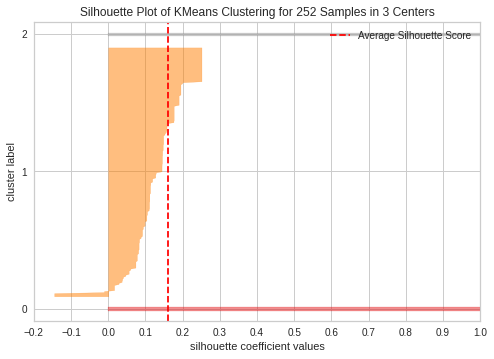

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 252 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [116]:
from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import SilhouetteVisualizer

# Visualize silhouette plots
from yellowbrick.cluster import SilhouetteVisualizer
visualizer = SilhouetteVisualizer(KMeans(n_clusters=3, random_state=42))
visualizer.fit(scaled_data1)
visualizer.show()

#### Elbow Method

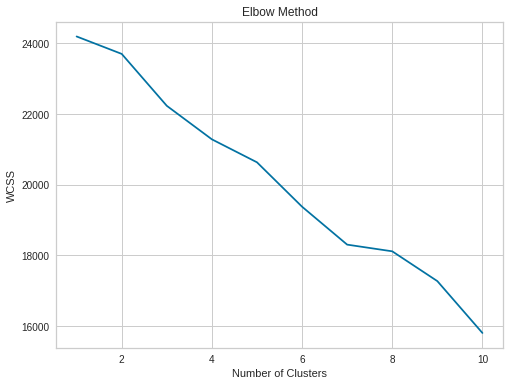

In [117]:
# Elbow method for K-means
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_data1)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

#### AMI score

The Adjusted Mutual Information (AMI) score is an evaluation metric used to measure the agreement between two partitions or clusterings of a dataset, typically comparing the predicted clusters with the true labels or ground truth. 
The AMI score is normalized and ranges from 0 to 1:

AMI score of 1: Perfect agreement between the predicted clusters and the true labels. The clustering algorithm has perfectly captured the underlying structure of the data.
AMI score of 0: No agreement between the predicted clusters and the true labels beyond what would be expected by chance. The clustering algorithm has not captured any meaningful structure in the data.
AMI score between 0 and 1: Partial agreement between the predicted clusters and the true labels. Higher values indicate better agreement.

In [154]:
from sklearn.metrics import adjusted_mutual_info_score

# Assuming you have the true labels available as 'true_labels'
true_labels = merged_data1['Target_encoded']

# Calculate AMI score for K-means clustering
ami_kmeans = adjusted_mutual_info_score(true_labels, kmeans_labels1)

# Calculate AMI score for hierarchical clustering with Ward linkage
ami_hierarchical_ward = adjusted_mutual_info_score(true_labels, hierarchical_labels_ward1)

# Calculate AMI score for hierarchical clustering with complete linkage
ami_hierarchical_complete = adjusted_mutual_info_score(true_labels, hierarchical_labels_complete1)

# Calculate AMI score for hierarchical clustering with average linkage
ami_hierarchical_average = adjusted_mutual_info_score(true_labels, hierarchical_labels_average1)

print("AMI Score (K-means):", ami_kmeans)
print("AMI Score (Hierarchical - Ward):", ami_hierarchical_ward)
print("AMI Score (Hierarchical - Complete):", ami_hierarchical_complete)
print("AMI Score (Hierarchical - Average):", ami_hierarchical_average)

AMI Score (K-means): 0.05782944087048201
AMI Score (Hierarchical - Ward): 0.07520409377379841
AMI Score (Hierarchical - Complete): 0.02230399088228568
AMI Score (Hierarchical - Average): 0.02230399088228568


In [128]:
# Convert 'Target' column to category data type
merged_data1['Target'] = merged_data1['Target'].astype('category')

# Get the 'Target' column as a Series (assuming it's the first column with that name)
target_series = merged_data1['Target'].iloc[:, 0]

print(target_series.dtypes)  # This should print 'category'

# Get unique categories
unique_classes1 = target_series.unique()

print(unique_classes1)

category
['Adult Females with Aging Conditions', 'Adults with Cardiovascular and Behavioral Con..., 'Mixed Age Group with Cognitive and Respirator...]
Categories (3, object): ['Adult Females with Aging Conditions', 'Adults with Cardiovascular and Behavioral Con..., 'Mixed Age Group with Cognitive and Respirator...]


In [119]:
# Calculate cluster means for oversampled data
cluster_means = X_resampled.groupby(y_resampled).mean()
print("Cluster Means:")
print(cluster_means)

Cluster Means:
                                                    Condition_Aging  \
Target                                                                
Adult Females with Aging Conditions                        0.023810   
Adults with Cardiovascular and Behavioral Condi...         0.000000   
Mixed Age Group with Cognitive and Respiratory ...         0.047619   

                                                    Condition_Alzheimer Disease 2 Due to Apoe4 Isoform  \
Target                                                                                                   
Adult Females with Aging Conditions                                                          0.000000    
Adults with Cardiovascular and Behavioral Condi...                                           0.000000    
Mixed Age Group with Cognitive and Respiratory ...                                           0.071429    

                                                    Condition_Arthroplasty  \
Target              

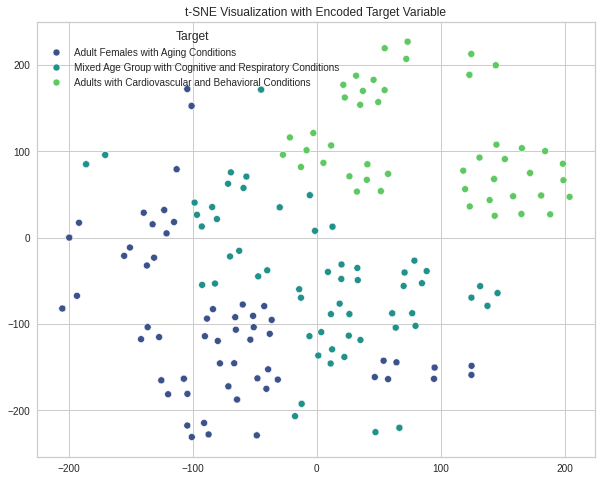

In [157]:
# Dimensionality reduction with t-SNE (if needed)
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_resampled)

# Plot the data
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_resampled, palette='viridis')
plt.title('t-SNE Visualization with Encoded Target Variable')
plt.show()

/tmp/ipykernel_8843/4051860953.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y_encoded1, palette='viridis')


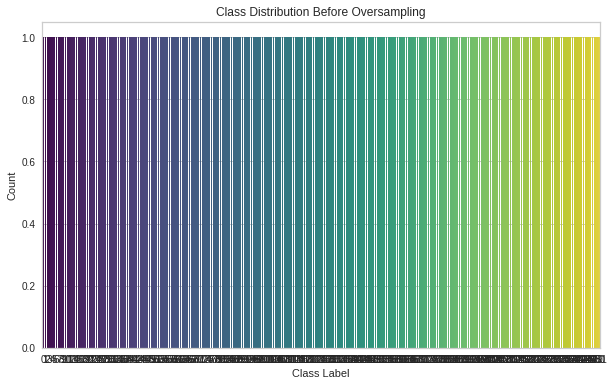

/tmp/ipykernel_8843/4051860953.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y_resampled, palette='viridis')


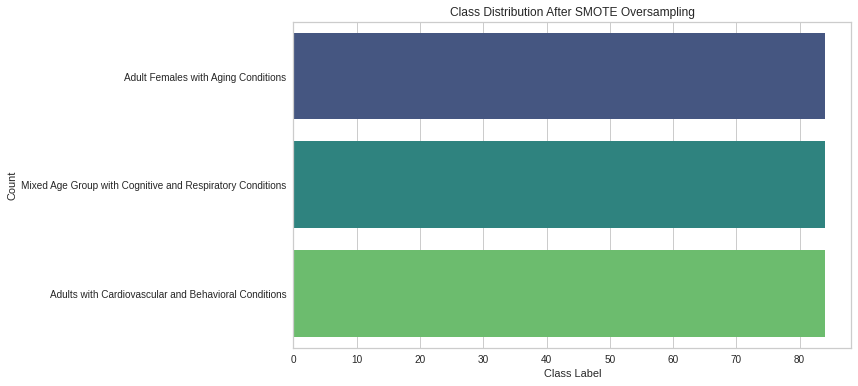

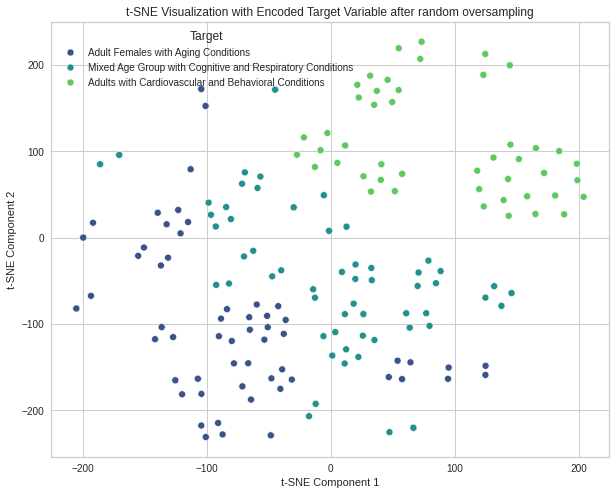

In [130]:
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE
import numpy as np

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded1 = label_encoder.fit_transform(merged_data1['Target_encoded']).astype(int)


# Plot the class distribution before oversampling
plt.figure(figsize=(10, 6))
sns.countplot(y_encoded1, palette='viridis')
plt.title('Class Distribution Before Oversampling')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()


# Plot the class distribution after oversampling
plt.figure(figsize=(10, 6))
sns.countplot(y_resampled, palette='viridis')
plt.title('Class Distribution After SMOTE Oversampling')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

# Dimensionality reduction with t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_resampled)


# Plot the data
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_resampled, palette='viridis')
plt.title('t-SNE Visualization with Encoded Target Variable after random oversampling')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


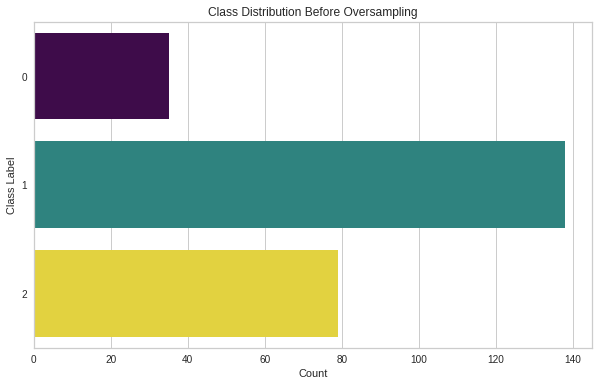

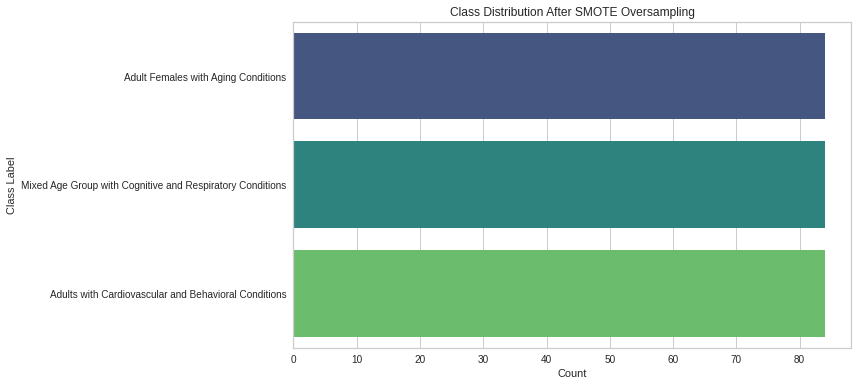

In [124]:
# Plot the class distribution before oversampling
plt.figure(figsize=(10, 6))
sns.countplot(y=y_encoded1, hue=y_encoded1, palette='viridis', legend=False)
plt.title('Class Distribution Before Oversampling')
plt.xlabel('Count')
plt.ylabel('Class Label')
plt.show()

# Plot the class distribution after oversampling
plt.figure(figsize=(10, 6))
sns.countplot(y=y_resampled, hue=y_resampled, palette='viridis', legend=False)
plt.title('Class Distribution After SMOTE Oversampling')
plt.xlabel('Count')
plt.ylabel('Class Label')
plt.show()


In [127]:
# Check for NaN or infinite values in exercise_features
nan_indices = np.isnan(X_resampled).any(axis=1)
inf_indices = np.isinf(X_resampled).any(axis=1)

if nan_indices.any() or inf_indices.any():
    print("NaN or infinite values found in exercise_features_resampled.")
    # Handle NaN or infinite values, e.g., by imputing them or removing corresponding rows
else:
    print("No NaN or infinite values found in exercise_features_resampled.")

# Check for NaN or infinite values in y_encoded
if np.isnan(y_encoded1).any() or np.isinf(y_encoded1).any():
    print("NaN or infinite values found in y_encoded1.")
    # Handle NaN or infinite values, if necessary
else:
    print("No NaN or infinite values found in y_encoded1.")


No NaN or infinite values found in exercise_features_resampled.
No NaN or infinite values found in y_encoded1.


In [131]:
unique_classes1, class_counts1 = np.unique(y_encoded1, return_counts=True)
print("Unique classes in y_encoded:", unique_classes1)
print("Class counts:", class_counts1)


Unique classes in y_encoded: [0 1 2]
Class counts: [ 35 138  79]


# Training the model

In [132]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [133]:
# Create a pipeline with preprocessing and the classifier
pipeline = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42))
])

In [134]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5, 10],
}

In [135]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 5, 10],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [136]:
# Get the cross-validation scores
cv_scores = grid_search.cv_results_['mean_test_score']

In [137]:
# Print the cross-validation scores
print("Cross-Validation Scores:")
for i, score in enumerate(cv_scores):
    print(f"Fold {i+1}: {score:.4f}")

Cross-Validation Scores:
Fold 1: 0.9950
Fold 2: 0.9950
Fold 3: 0.9950
Fold 4: 0.9950
Fold 5: 0.9950
Fold 6: 0.9950
Fold 7: 0.9950
Fold 8: 0.9950
Fold 9: 0.9950
Fold 10: 0.9950
Fold 11: 0.9950
Fold 12: 0.9950
Fold 13: 0.9950
Fold 14: 0.9950
Fold 15: 0.9950
Fold 16: 0.9950
Fold 17: 0.9950
Fold 18: 0.9950
Fold 19: 0.9950
Fold 20: 0.9950
Fold 21: 0.9950
Fold 22: 0.9950
Fold 23: 0.9950
Fold 24: 0.9950
Fold 25: 0.9950
Fold 26: 0.9950
Fold 27: 0.9950


In [138]:
# Get the best model from grid search
best_model = grid_search.best_estimator_
best_model

Pipeline(steps=[('classifier', RandomForestClassifier(random_state=42))])

In [139]:
best_model.fit(X_train, y_train)

Pipeline(steps=[('classifier', RandomForestClassifier(random_state=42))])

In [140]:
# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

Test set accuracy: 1.0000
                                                           precision    recall  f1-score   support

                      Adult Females with Aging Conditions       1.00      1.00      1.00        23
     Adults with Cardiovascular and Behavioral Conditions       1.00      1.00      1.00        15
Mixed Age Group with Cognitive and Respiratory Conditions       1.00      1.00      1.00        13

                                                 accuracy                           1.00        51
                                                macro avg       1.00      1.00      1.00        51
                                             weighted avg       1.00      1.00      1.00        51



In [141]:
from sklearn.pipeline import Pipeline
print(best_model)

Pipeline(steps=[('classifier', RandomForestClassifier(random_state=42))])


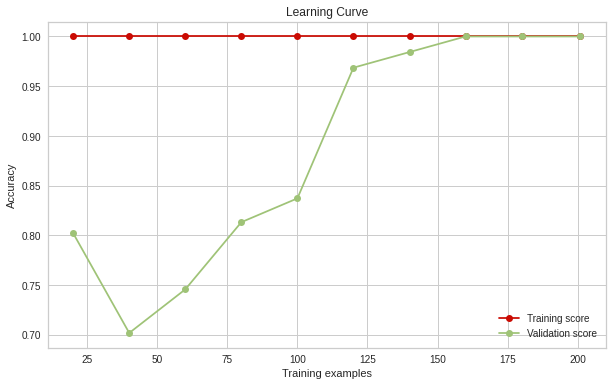

In [142]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Generate the learning curve data
train_sizes, train_scores, val_scores = learning_curve(best_model, X_resampled, y_resampled, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='r', label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', color='g', label='Validation score')
plt.xlabel('Training examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.show()

In [143]:
model = best_model.named_steps['classifier']

Selected features: Index(['feature_17', 'feature_46', 'feature_64', 'feature_80', 'feature_84',
       'feature_87', 'feature_88', 'feature_90', 'feature_91', 'feature_93'],
      dtype='object')


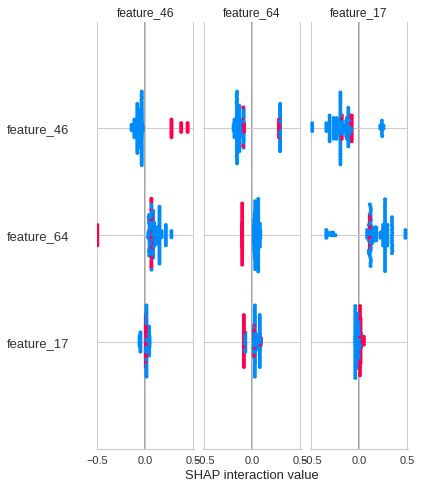

In [144]:
# Import the necessary modules
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
import shap
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Create a random forest classifier
rf_model = RandomForestClassifier(random_state=42)

# Create an RFE object with the desired number of features to select
rfe = RFE(estimator=rf_model, n_features_to_select=10)

# Fit RFE to the training data
rfe.fit(X_train, y_train)

# Convert X_train to a dense NumPy array
X_train_dense = X_train.to_numpy()

# Convert X_train to a pandas DataFrame
X_train_df = pd.DataFrame(X_train_dense, columns=[f'feature_{i}' for i in range(X_train_dense.shape[1])])

# Get the selected features
selected_features = X_train_df.columns[rfe.support_]

# Print the selected features
print("Selected features:", selected_features)

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Fit the random forest model on the selected features and encoded target
rf_model.fit(X_train_df[selected_features], y_train_encoded)

# Compute SHAP values for feature importance
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train_df[selected_features])

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_train_df[selected_features], plot_type="bar")

In [145]:
print(f"y_test data type: {y_test.dtype}")
print(f"y_pred data type: {y_pred.dtype}")

y_test data type: object
y_pred data type: object


In [149]:
# Convert X_test to a pandas DataFrame with the same column names as X_train_df
X_test_df = pd.DataFrame.from_records(X_test, columns=X_train_df.columns, index=None)

# Predict on the test set
y_pred = rf_model.predict(X_test_df[selected_features])

# Convert y_test and y_pred to strings
y_test = label_encoder.inverse_transform(y_test)
y_pred = label_encoder.inverse_transform(y_pred)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")


/tmp/ipykernel_8843/2235244279.py:2: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  X_test_df = pd.DataFrame.from_records(X_test, columns=X_train_df.columns, index=None)


KeyError: "None of [Index(['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',\n       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',\n       'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14',\n       'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19',\n       'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24',\n       'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29',\n       'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34',\n       'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39',\n       'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44',\n       'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49',\n       'feature_50', 'feature_51', 'feature_52', 'feature_53', 'feature_54',\n       'feature_55', 'feature_56', 'feature_57', 'feature_58', 'feature_59',\n       'feature_60', 'feature_61', 'feature_62', 'feature_63', 'feature_64',\n       'feature_65', 'feature_66', 'feature_67', 'feature_68', 'feature_69',\n       'feature_70', 'feature_71', 'feature_72', 'feature_73', 'feature_74',\n       'feature_75', 'feature_76', 'feature_77', 'feature_78', 'feature_79',\n       'feature_80', 'feature_81', 'feature_82', 'feature_83', 'feature_84',\n       'feature_85', 'feature_86', 'feature_87', 'feature_88', 'feature_89',\n       'feature_90', 'feature_91', 'feature_92', 'feature_93', 'feature_94',\n       'feature_95'],\n      dtype='object')] are in the [columns]"

In [ ]:
# User Input and Personalized Recommendations
# Step 1: Enter demographic information
age = input("Enter your age: ")
sex = input("Enter your sex: ")
race = input("Enter your race: ")
gender = input("Enter your gender: ")
comorbidities = input("Enter any comorbidities (separated by commas if multiple): ").split(',')

Enter your age: 
Enter your sex: 
Enter your race: 
Enter your gender: 
Enter any comorbidities (separated by commas if multiple): 


In [ ]:
# Step 2: Confirm weekly exercise goal
weekly_goal = input("Confirm your weekly exercise goal (e.g., 150 mins MVPA, plus strength training): ")

Confirm your weekly exercise goal (e.g., 150 mins MVPA, plus strength training): 


In [ ]:
# Step 3: Preference
start_preference = input("Do you prefer a gradual start or an immediate goal? ")
exercise_variety = input("Do you prefer new types of exercise every day or consistency? ")

Do you prefer a gradual start or an immediate goal? 
Do you prefer new types of exercise every day or consistency? 


In [ ]:
# Step 4: Location of exercise
exercise_location = input("Where do you plan to exercise (YMCA, Planet Fitness, other gym, home)? ")

Where do you plan to exercise (YMCA, Planet Fitness, other gym, home)? 


In [ ]:
# Step 5: Select days and times of exercise
days_of_exercise = input("Select the days of the week you plan to exercise (separated by commas if multiple): ").split(',')
times_of_exercise = input("Select the times of the day you plan to exercise (separated by commas if multiple): ").split(',')

Select the days of the week you plan to exercise (separated by commas if multiple): 
Select the times of the day you plan to exercise (separated by commas if multiple): 


In [ ]:
# Step 6: Optional preference of exercise machine
exercise_machine_preference = input("Enter your preference of exercise machine (e.g., treadmill, elliptical): ")


Enter your preference of exercise machine (e.g., treadmill, elliptical): 


In [ ]:
# Step 7: Coordinate exercise buddy
exercise_buddy = input("Do you want to coordinate/have a potential exercise buddy? ")

Do you want to coordinate/have a potential exercise buddy? 


In [ ]:
# Step 8: Create appearance of virtual coach

In [ ]:
# Displaying entered information
print("\nEntered information:")
print(f"Age: {age}")
print(f"Sex: {sex}")
print(f"Race: {race}")
print(f"Gender: {gender}")
print(f"Comorbidities: {comorbidities}")
print(f"Weekly exercise goal: {weekly_goal}")
print(f"Start preference: {start_preference}")
print(f"Exercise variety preference: {exercise_variety}")
print(f"Exercise location: {exercise_location}")
print(f"Days of exercise: {days_of_exercise}")
print(f"Times of exercise: {times_of_exercise}")
print(f"Exercise machine preference: {exercise_machine_preference}")
print(f"Exercise buddy coordination: {exercise_buddy}")


Entered information:
Age: 
Sex: 
Race: 
Gender: 
Comorbidities: ['']
Weekly exercise goal: 
Start preference: 
Exercise variety preference: 
Exercise location: 
Days of exercise: ['']
Times of exercise: ['']
Exercise machine preference: 
Exercise buddy coordination: 


In [ ]:
# User profile data
user_data = {
    'Sex': [sex],
    'Age': [age],
    'Enrollment': [100],
    'Comorbidities': [', '.join(comorbidities)],
    'Weekly_Goal': [weekly_goal],
    'Start_Preference': [start_preference],
    'Exercise_Variety': [exercise_variety],
    'Exercise_Location': [exercise_location],
    'Exercise_Machine_Preference': [exercise_machine_preference],
    'Exercise_Buddy': [exercise_buddy]
}

In [ ]:
# Create a DataFrame from the user data
user_df = pd.DataFrame(user_data)


In [ ]:
# Align the columns of user_df with the training data columns
missing_cols = set(X.columns) - set(user_df.columns)
for col in missing_cols:
    user_df[col] = 0

user_df = user_df[X.columns]

NameError: name 'X' is not defined

In [ ]:
# Convert relevant columns to appropriate data types
user_df['Age'] = user_df['Age'].astype(str)
user_df['Enrollment'] = user_df['Enrollment'].astype(int)

In [ ]:
# Preprocess the user data
user_data_imputed = imputer.transform(user_df)
user_data_encoded = ct.transform(user_data_imputed)
user_data_scaled = scaler.transform(user_data_encoded)

In [ ]:
# Predict the exercise cluster for the new user
user_cluster = best_model.predict(user_data_scaled)[0]

In [ ]:
# Personalized exercise recommendations based on user cluster and preferences
recommendations = []

if user_cluster == 'Adult Females with Aging Conditions':
    recommendations = [
        f"Focus on low-impact exercises like {exercise_machine_preference} or yoga, considering your age and any comorbidities such as {', '.join(comorbidities)}.",
        "Incorporate strength training exercises to maintain muscle mass and bone density.",
        "Include balance and stability exercises to reduce the risk of falls.",
        "Consult with a healthcare professional before starting an exercise program."
    ]
elif user_cluster == 'Adults with Cardiovascular and Behavioral Conditions':
    recommendations = [
        f"Engage in moderate-intensity cardiovascular exercises like {exercise_machine_preference} or cycling, considering your weekly goal of {weekly_goal}.",
        "Include strength training exercises to improve overall fitness and manage weight.",
        "Consider stress-reducing activities like meditation or deep breathing exercises.",
        "Monitor blood pressure and heart rate during exercise and consult with a healthcare professional."
    ]
elif user_cluster == 'Mixed Age Group with Cognitive and Respiratory Conditions':
    recommendations = [
        "Engage in activities that promote cognitive function, such as puzzles or memory games.",
        "Include breathing exercises and activities that improve lung capacity.",
        f"Participate in group exercise classes or social activities to maintain engagement and motivation, considering your preference for {exercise_variety}.",
        "Consult with a healthcare professional to design an appropriate exercise plan."
    ]

In [ ]:
# Display personalized exercise recommendations
print("\nPersonalized Exercise Recommendations:")
for recommendation in recommendations:
    print("- " + recommendation)

In [ ]:
# Personalized exercise plan based on user's preferences and exercise session details
exercise_plan = [...]

In [ ]:
# Display personalized exercise plan
print("\nPersonalized Exercise Plan:")
for plan_item in exercise_plan:
    print("- " + plan_item)

##Clustering

Apply a clustering algorithm (e.g., K-means) to group similar participants based on their characteristics and exercise-related features.
Determine the optimal number of clusters using techniques like the elbow method or silhouette analysis.
Assign cluster labels to each participant in the dataset.

## Oversampling with SMOTE

In [ ]:

# Oversampling with SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)# Reduce the number of neighbors
exercise_features_resampled, y_resampled = smote.fit_resample(exercise_features, exercise_data['Cluster'])

## t-SNE Visualization

In [ ]:
# Perform t-SNE on the oversampled data
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(exercise_features_resampled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=pd.Series(y_resampled).map(cluster_labels), palette='viridis')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Clusters')
plt.show()

## clusters using Principal Component Analysis (PCA) for dimensionality reduction:

In [ ]:
from sklearn.decomposition import PCA

# Perform PCA on the oversampled data
pca = PCA(n_components=2, random_state=42)
pca_features = pca.fit_transform(exercise_features_resampled)

# Create a DataFrame with PCA features and cluster labels
pca_df = pd.DataFrame(data=pca_features, columns=['PC1', 'PC2'])
pca_df['Cluster'] = y_resampled

# Scatter plot of clusters using PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of Clusters (PCA)')
plt.legend(title='Cluster', labels=[cluster_labels[i] for i in sorted(cluster_labels.keys())])
plt.show()

## Density plots

In [ ]:


# Create a DataFrame with oversampled data
oversampled_data = pd.concat([pd.DataFrame(exercise_features_resampled), pd.DataFrame(y_resampled, columns=['Cluster'])], axis=1)

# Density Plots
for feature in exercise_features_resampled.columns:
    plt.figure(figsize=(8, 6))
    for cluster in oversampled_data['Cluster'].unique():
        sns.kdeplot(oversampled_data[oversampled_data['Cluster'] == cluster][feature], label=cluster_labels[cluster])
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.title(f'Density Plot - {feature}')
    plt.legend()
    plt.show()

##Target Variable Creation

Analyze the characteristics and exercise patterns of each cluster.
Assign meaningful labels to each cluster based on their characteristics (e.g., "highly active," "moderately active," "sedentary").
Create a new target variable in the dataset based on the assigned cluster labels.

In [ ]:
# Calculate cluster means for oversampled data
cluster_means = exercise_features_resampled.groupby(y_resampled).mean()
print("Cluster Means:")
print(cluster_means)

Cluster Means:
                                                    Condition_Aging  \
Target                                                                
Adult Females with Aging Conditions                        0.051282   
Adults with Cardiovascular and Behavioral Condi...         0.000000   
Mixed Age Group with Cognitive and Respiratory ...         0.043956   

                                                    Condition_Alzheimer Disease 2 Due to Apoe4 Isoform  \
Target                                                                                                   
Adult Females with Aging Conditions                                                          0.000000    
Adults with Cardiovascular and Behavioral Condi...                                           0.000000    
Mixed Age Group with Cognitive and Respiratory ...                                           0.065934    

                                                    Condition_Arthroplasty  \
Target              

Based on the cluster means output, to analyze the patterns and characteristics of each cluster:

### Cluster 0: Adult Females with Aging Conditions

High mean values for 'Condition_Aging' (0.031579) and 'Age_ADULT' (0.589474), indicating a cluster focused on aging-related conditions in adults.

Presence of 'Condition_Cognitive Function, Preclinical' (mean: 0.052632), suggesting cognitive function and potential preclinical conditions.

Highest mean for 'Age_CHILD' (0.210526), indicating a mix of adult and child participants.

Predominance of female participants (mean: 1.0 for 'Sex_FEMALE').

Interventions related to 'RADIATION' (mean: 0.147368).

### Cluster 1: Adults with Cardiovascular and Behavioral Conditions

High mean values for 'Condition_Cardiovascular Diseases' (0.063158) and 'Condition_Cigarette Smoking' (0.126316), suggesting a cluster focused on cardiovascular diseases and behavioral risk factors.

Presence of 'Condition_Child Mental Disorders' (mean: 0.021053), indicating a mix of conditions related to mental health.

Almost exclusively adult participants (mean: 0.978947 for 'Age_ADULT').

Mix of male (mean: 0.126316 for 'Sex_MALE') and female participants.

### Cluster 2: Mixed Age Group with Cognitive and Respiratory Conditions

High mean values for 'Condition_Alzheimer Disease 2 Due to Apoe4 Isoform' (0.063158), 'Condition_Arthroplasty' (0.042105), and 'Condition_Asthma in Children' (0.021053), suggesting a cluster focused on cognitive conditions, joint-related conditions, and respiratory conditions.

Presence of 'Condition_Cardiovascular Diseases' (0.021053) and 'Condition_Cardiovascular Risk Factor' (0.021053), indicating a mix of cardiovascular-related conditions.

Diverse age group with a mix of 'Age_ADULT' (0.747368), 'Age_CHILD, ADULT, OLDER_ADULT' (0.126316), and 'Age_OLDER_ADULT' (0.084211).

Exclusively female participants (mean: 1.0 for 'Sex_ALL', which is coded as female).

In [ ]:

exercise_data['Target'] = exercise_data['Cluster'].map(cluster_labels)

KeyError: 'Cluster'

In [ ]:
exercise_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182 entries, 0 to 1062
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   NCT Number                  182 non-null    object 
 1   Conditions                  182 non-null    object 
 2   Interventions               182 non-null    object 
 3   Primary Outcome Measures    182 non-null    object 
 4   Secondary Outcome Measures  142 non-null    object 
 5   Other Outcome Measures      21 non-null     object 
 6   Sex                         182 non-null    object 
 7   Age                         182 non-null    object 
 8   Enrollment                  182 non-null    float64
 9   Other IDs                   182 non-null    object 
 10  Total number of studies     0 non-null      object 
 11  1158                        0 non-null      object 
 12  Unnamed: 2                  0 non-null      float64
 13  Unnamed: 3                  0 non-

##Model Training and Evaluation

Split the dataset into features (X) and the target variable (y).
Train a predictive model (e.g., Random Forest) using the cluster-based target variable.
Evaluate the model's performance using appropriate metrics and cross-validation techniques.

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV

# Merge exercise_features and exercise_data based on index
merged_data = pd.concat([exercise_data.reset_index(drop=True), exercise_features.reset_index(drop=True)], axis=1)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(exercise_features_resampled, y_resampled, test_size=0.2, random_state=42)

# Identify columns with non-numerical values
non_numeric_columns = X_train.select_dtypes(include=['object']).columns.tolist()

# Check if there are any non-numeric columns
if non_numeric_columns:
    # Encode categorical features
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    preprocessor = ColumnTransformer(transformers=[('cat', categorical_transformer, non_numeric_columns)])
else:
    # If no non-numeric columns, set preprocessor to 'passthrough'
    preprocessor = 'passthrough'

# Create a pipeline with preprocessing and the classifier
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5, 10]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, error_score='raise')
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Test set accuracy: 1.0
                                                           precision    recall  f1-score   support

                      Adult Females with Aging Conditions       1.00      1.00      1.00        10
     Adults with Cardiovascular and Behavioral Conditions       1.00      1.00      1.00         9
Mixed Age Group with Cognitive and Respiratory Conditions       1.00      1.00      1.00        17

                                                 accuracy                           1.00        36
                                                macro avg       1.00      1.00      1.00        36
                                             weighted avg       1.00      1.00      1.00        36



In [ ]:

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
import random

# Merge exercise_features and exercise_data based on index
merged_data = pd.concat([exercise_data.reset_index(drop=True), exercise_features.reset_index(drop=True)], axis=1)

# Identify columns with non-numerical values
non_numeric_columns = X_resampled.select_dtypes(include=['object']).columns.tolist()

# Check if there are any non-numeric columns
if non_numeric_columns:
    # Encode categorical features
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    preprocessor = ColumnTransformer(transformers=[('cat', categorical_transformer, non_numeric_columns)])
else:
    # If no non-numeric columns, set preprocessor to 'passthrough'
    preprocessor = 'passthrough'

# Create a pipeline with preprocessing and the classifier (without bootstrap)
base_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Create a separate pipeline with preprocessing and the classifier (with bootstrap)
bootstrap_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, bootstrap=True))
])

# Define the parameter distributions for RandomizedSearchCV
param_distributions = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5, 10]
}

# Perform randomized search with cross-validation (without bootstrap)
random_search = RandomizedSearchCV(base_pipeline, param_distributions=param_distributions, cv=5, scoring='f1_macro', n_jobs=-1, error_score='raise', n_iter=10, random_state=42)
random_search.fit(X_resampled, y_resampled)  # Fit RandomizedSearchCV to the data

# Get the best model from randomized search (without bootstrap)
best_base_model = random_search.best_estimator_

# Perform randomized search with cross-validation (with bootstrap)
bootstrap_random_search = RandomizedSearchCV(bootstrap_pipeline, param_distributions=param_distributions, cv=5, scoring='f1_macro', n_jobs=-1, error_score='raise', n_iter=10, random_state=42)
bootstrap_random_search.fit(X_resampled, y_resampled)  # Fit RandomizedSearchCV to the data

# Get the best model from randomized search (with bootstrap)
best_bootstrap_model = bootstrap_random_search.best_estimator_

# Evaluate the best model using bagging and boosting ensemble methods
bagging_classifier = BaggingClassifier(base_estimator=best_bootstrap_model, n_estimators=100, random_state=42)
boosting_classifier = AdaBoostClassifier(base_estimator=best_base_model, n_estimators=100, random_state=42)

# Print the best_base_model to inspect its parameters
print(best_base_model)

# Try using a different base_estimator that supports sample weights
best_base_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Create a new AdaBoostClassifier with the updated base_estimator
boosting_classifier = AdaBoostClassifier(base_estimator=best_base_model, n_estimators=100, random_state=42)

# Perform cross-validation on the updated ensemble method
boosting_scores = cross_val_score(boosting_classifier, X_resampled, y_resampled, cv=5, scoring='f1_macro', n_jobs=-1)

# Print the cross-validation scores
print(f"\nBoosting ensemble cross-validation scores: {boosting_scores}")
print(f"Mean boosting ensemble score: {boosting_scores.mean():.3f}")

print(f"\nBagging ensemble cross-validation scores: {bagging_scores}")
print(f"Mean bagging ensemble score: {bagging_scores.mean():.3f}")

print(f"\nBoosting ensemble cross-validation scores: {boosting_scores}")
print(f"Mean boosting ensemble score: {boosting_scores.mean():.3f}")

NameError: name 'X_resampled' is not defined

## Sorensen-Dice Index

In [ ]:
def sorensen_dice(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    dice = 2 * tp / (2 * tp + fp + fn)
    return dice.mean()

sorensen_dice_index = sorensen_dice(y_test, y_pred)
print(f"Sorensen-Dice Index: {sorensen_dice_index}")

### User Input and Personalized Recommendations

Use the trained model to predict the exercise cluster for new app users based on their characteristics and preferences.
Personalize the app experience and provide exercise recommendations based on the predicted cluster.
Collect user feedback and exercise data to continuously improve the model and refine the clustering.

In [ ]:
# Import necessary libraries
import pandas as pd

# Step 1: Enter demographic information
age = input("Enter your age: ")
sex = input("Enter your sex: ")
race = input("Enter your race: ")
gender = input("Enter your gender: ")
comorbidities = input("Enter any comorbidities (separated by commas if multiple): ").split(',')

# Step 2: Confirm weekly exercise goal
weekly_goal = input("Confirm your weekly exercise goal (e.g., 150 mins MVPA, plus strength training): ")

# Step 3: Preference
start_preference = input("Do you prefer a gradual start or an immediate goal? ")
exercise_variety = input("Do you prefer new types of exercise every day or consistency? ")

# Step 4: Location of exercise
exercise_location = input("Where do you plan to exercise (YMCA, Planet Fitness, other gym, home)? ")

# Step 5: Select days and times of exercise
days_of_exercise = input("Select the days of the week you plan to exercise (separated by commas if multiple): ").split(',')
times_of_exercise = input("Select the times of the day you plan to exercise (separated by commas if multiple): ").split(',')

# Step 6: Optional preference of exercise machine
exercise_machine_preference = input("Enter your preference of exercise machine (e.g., treadmill, elliptical): ")

# Step 7: Coordinate exercise buddy
exercise_buddy = input("Do you want to coordinate/have a potential exercise buddy? ")

# Step 8: Create appearance of virtual coach
# This step involves more complex graphics and is beyond the scope of this code snippet

# Displaying entered information
print("\nEntered information:")
print(f"Age: {age}")
print(f"Sex: {sex}")
print(f"Race: {race}")
print(f"Gender: {gender}")
print(f"Comorbidities: {comorbidities}")
print(f"Weekly exercise goal: {weekly_goal}")
print(f"Start preference: {start_preference}")
print(f"Exercise variety preference: {exercise_variety}")
print(f"Exercise location: {exercise_location}")
print(f"Days of exercise: {days_of_exercise}")
print(f"Times of exercise: {times_of_exercise}")
print(f"Exercise machine preference: {exercise_machine_preference}")
print(f"Exercise buddy coordination: {exercise_buddy}")


In [ ]:
# Step 5: Integration with the Exercise Habit App
# Predict exercise cluster for the new user based on their characteristics and preferences
user_data = pd.DataFrame({
    'Age': [age],
    'Sex': [sex],
    'Race': [race],
    'Gender': [gender],
    'Comorbidities': [', '.join(comorbidities)],
    'Weekly_Goal': [weekly_goal],
    'Start_Preference': [start_preference],
    'Exercise_Variety': [exercise_variety],
    'Exercise_Location': [exercise_location],
    'Exercise_Machine_Preference': [exercise_machine_preference],
    'Exercise_Buddy': [exercise_buddy]
})


In [ ]:
import datetime
import time

# Step 1: Generate cardio and strength training exercises
# This step would require a database of exercises and routines, and is beyond the scope of this code snippet

# Step 2: User receives notification
notification_time = datetime.datetime.now() + datetime.timedelta(minutes=15)  # Notification 15 minutes before exercise session
print(f"Notification: Your exercise session will start at {notification_time.strftime('%H:%M')}.")

# Step 3: User starts recording exercise time
input("Press 'Enter' to begin recording exercise time.")

# Simulate exercise time recording
print("Exercise session started.")
time.sleep(120)  # Simulating 2 minutes of exercise time

# Step 4: User ends exercise session
input("Press 'Enter' to end exercise session.")

# Simulate exercise session end
print("Exercise session ended.")

# Step 5: Checkmark or X on types of exercises used
exercise_types = ['Cardio', 'Strength Training']  # List of exercise types
print("Types of exercises:")
for idx, exercise in enumerate(exercise_types):
    print(f"{idx+1}. {exercise}")

user_input = input("Enter the numbers of exercises used (separated by commas if multiple): ")
used_exercises = [exercise_types[int(i)-1] for i in user_input.split(',')]

# Step 6: Did they use another machine or not exercise?
if 'Strength Training' in used_exercises:
    additional_machine = input("Did you use another machine for strength training? (yes/no) ")
    if additional_machine.lower() == 'yes':
        additional_machine_used = input("Enter the name of the additional machine used: ")
        print(f"Additional machine used: {additional_machine_used}")
    else:
        print("No additional machine used.")
elif 'Cardio' in used_exercises:
    # If only cardio was used, we can ask if the user used any other cardio machine
    additional_machine = input("Did you use another cardio machine? (yes/no) ")
    if additional_machine.lower() == 'yes':
        additional_machine_used = input("Enter the name of the additional cardio machine used: ")
        print(f"Additional cardio machine used: {additional_machine_used}")
    else:
        print("No additional cardio machine used.")

# Step 7: Give reward if exercise time goal is met (gamification)
exercise_time_goal = 150  # Example exercise time goal in minutes
exercise_time = int(input("Enter the total exercise time (in minutes): "))
if exercise_time >= exercise_time_goal:
    print("Congratulations! You've met your exercise time goal.")
    # Provide some reward or feedback for achieving the goal
else:
    print("Keep up the good work! You'll reach your goal with consistency.")


In [ ]:
# Preprocess the user data
user_data_encoded = pd.get_dummies(user_data)


In [ ]:
# Align the columns of user_data_encoded with the model's feature columns
missing_cols = set(X.columns) - set(user_data_encoded.columns)
for col in missing_cols:
    user_data_encoded[col] = 0
user_data_encoded = user_data_encoded[X.columns]

In [ ]:
# Align the columns of user_data_encoded with the model's feature columns
missing_cols = set(X.columns) - set(user_data_encoded.columns)
for col in missing_cols:
    user_data_encoded[col] = 0
user_data_encoded = user_data_encoded[X.columns]


In [ ]:
print("Features in X:")
print(X.columns)

print("\nFeatures in user_data_encoded:")
print(user_data_encoded.columns)

In [ ]:
missing_cols = set(X.columns) - set(user_data_encoded.columns)
for col in missing_cols:
    user_data_encoded[col] = 0

In [ ]:
user_data_encoded = user_data_encoded[X.columns]

In [ ]:
import pandas as pd
from scipy.sparse import csr_matrix

# Convert X_train from csr_matrix to DataFrame
X_train_array = X_train.toarray()  # Convert csr_matrix to array
X_train_df = pd.DataFrame(X_train_array)

# Truncate columns if necessary
if X_train_array.shape[1] > len(X.columns):
    X_train_df = X_train_df.iloc[:, :len(X.columns)]
    X_train_df.columns = X.columns

# Create a new RandomForestClassifier model
new_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the new model with feature names
new_model.fit(X_train_df, y_train)

# Predict the exercise cluster for the new user
user_cluster = new_model.predict(user_data_encoded)

In [ ]:
# Generate personalized exercise plan based on user's preferences
print("\nPersonalized Exercise Plan:")
print(f"Weekly Goal: {weekly_goal}")
print(f"Start Preference: {start_preference}")
print(f"Exercise Variety: {exercise_variety}")
print(f"Exercise Location: {exercise_location}")
print(f"Days of Exercise: {', '.join(days_of_exercise)}")
print(f"Times of Exercise: {', '.join(times_of_exercise)}")
print(f"Exercise Machine Preference: {exercise_machine_preference}")
print(f"Exercise Buddy: {exercise_buddy}")

# Provide personalized exercise recommendations based on the user's cluster and preferences
# ...

# Simulate exercise session
# ...

# Provide reward or feedback based on exercise performance
# ...

In [ ]:
# User profile data
user_data = {
    'Sex': [sex],
    'Age': [age],
    'Enrollment': [100],
    'Comorbidities': [', '.join(comorbidities)],
    'Weekly_Goal': [weekly_goal],
    'Start_Preference': [start_preference],
    'Exercise_Variety': [exercise_variety],
    'Exercise_Location': [exercise_location],
    'Exercise_Machine_Preference': [exercise_machine_preference],
    'Exercise_Buddy': [exercise_buddy]
}

# Create a DataFrame from the user data
user_df = pd.DataFrame(user_data)

# Align the columns of user_df with the training data columns
missing_cols = set(X.columns) - set(user_df.columns)
for col in missing_cols:
    user_df[col] = 0

user_df = user_df[X.columns]

# Convert relevant columns to appropriate data types
#user_df['Sex'] = user_df['Sex'].astype(str)
user_df['Age'] = user_df['Age'].astype(str)
user_df['Enrollment'] = user_df['Enrollment'].astype(int)

# Preprocess the user data
if non_numeric_columns:
    # Encode categorical features
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    preprocessor = ColumnTransformer(transformers=[('cat', categorical_transformer, non_numeric_columns)])
    user_data_encoded = preprocessor.transform(user_df)
else:
    # If no non-numeric columns, the user_dat
    user_cluster = model.predict(user_data_encoded)[0]

# Personalized exercise recommendations based on user cluster and preferences
recommendations = []

if user_cluster == 'Adult Females with Aging Conditions':
    recommendations = [
        f"Focus on low-impact exercises like {exercise_machine_preference} or yoga, considering your age and any comorbidities such as {', '.join(comorbidities)}.",
        "Incorporate strength training exercises to maintain muscle mass and bone density.",
        "Include balance and stability exercises to reduce the risk of falls.",
        "Consult with a healthcare professional before starting an exercise program."
    ]
elif user_cluster == 'Adults with Cardiovascular and Behavioral Conditions':
    recommendations = [
        f"Engage in moderate-intensity cardiovascular exercises like {exercise_machine_preference} or cycling, considering your weekly goal of {weekly_goal}.",
        "Include strength training exercises to improve overall fitness and manage weight.",
        "Consider stress-reducing activities like meditation or deep breathing exercises.",
        "Monitor blood pressure and heart rate during exercise and consult with a healthcare professional."
    ]
elif user_cluster == 'Mixed Age Group with Cognitive and Respiratory Conditions':
    recommendations = [
        "Engage in activities that promote cognitive function, such as puzzles or memory games.",
        "Include breathing exercises and activities that improve lung capacity.",
        f"Participate in group exercise classes or social activities to maintain engagement and motivation, considering your preference for {exercise_variety}.",
        "Consult with a healthcare professional to design an appropriate exercise plan."
    ]

# Display personalized exercise recommendations
print("\nPersonalized Exercise Recommendations:")
for recommendation in recommendations:
    print("- " + recommendation)

In [ ]:
# Personalized exercise plan based on user's preferences and exercise session details
exercise_plan = [
    f"Weekly Goal: {weekly_goal}",
    f"Start Preference: {start_preference}",
    f"Exercise Variety: {exercise_variety}",
    f"Exercise Location: {exercise_location}",
    f"Days of Exercise: {', '.join(days_of_exercise)}",
    f"Times of Exercise: {', '.join(times_of_exercise)}",
    f"Exercise Machine Preference: {exercise_machine_preference}",
    f"Exercise Buddy: {exercise_buddy}"
]

# Display personalized exercise plan
print("\nPersonalized Exercise Plan:")
for plan_item in exercise_plan:
    print("- " + plan_item)

In [ ]:
!pip install datasets

In [ ]:
!pip install accelerate

In [ ]:
!pip install transformers[torch]

In [ ]:
import pandas as pd
from transformers import AutoConfig, AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Trainer
from datasets import Dataset, load_metric
from typing import Dict

# Load the data
conditions = ["Obesity", "Diabetes", "Hypertension", "Arthritis", "Heart Disease"]
interventions = ["Exercise intervention for Obesity", "Exercise intervention for Diabetes", "Exercise intervention for Hypertension", "Exercise intervention for Arthritis", "Exercise intervention for Heart Disease"]
data = pd.DataFrame({'condition': conditions, 'intervention': interventions})

# Create a Dataset from the DataFrame
dataset = Dataset.from_pandas(data)

# Preprocess the data
def preprocess_data(example):
    inputs = example['condition']
    targets = example['intervention']
    model_inputs = tokenizer(inputs, max_length=128, padding="max_length", truncation=True, return_tensors="pt")
    labels = tokenizer(targets, max_length=128, padding="max_length", truncation=True, return_tensors="pt")["input_ids"]
    model_inputs["labels"] = labels
    return model_inputs

# Load the pre-trained model and tokenizer
config = AutoConfig.from_pretrained("t5-base")
tokenizer = AutoTokenizer.from_pretrained("t5-base")
model = AutoModelForSeq2SeqLM.from_pretrained("t5-base", config=config)

# Preprocess the dataset
dataset = dataset.map(preprocess_data, batched=True, remove_columns=dataset.column_names)
# Define the data collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# Set up the training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./models",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
)

# Set up the metric for evaluation
metric = load_metric("sacrebleu")

# Define the training function
def compute_metrics(eval_preds: Dict):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}
    return result

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    eval_dataset=None,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Generate exercise interventions for new conditions
new_conditions = ["Asthma", "Depression"]
inputs = tokenizer(new_conditions, padding=True, return_tensors="pt")
generated_ids = trainer.model.generate(inputs["input_ids"], max_length=50, num_beams=5, early_stopping=True)
generated_interventions = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]

print("Generated Exercise Interventions:")
for condition, intervention in zip(new_conditions, generated_interventions):
    print(f"{condition}: {intervention}")

In [ ]:
https://pub.dev/packages/google_sign_in

In [ ]:
https://pub.dev/packages/sign_in_with_apple